In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import georinex as gr
import xarray as xr
from scipy.constants import c

import pathlib
import subprocess

In [2]:
week = 2109

def mask_zeros(x):
    return x.where(x != 0)

In [3]:
def load(path):
    x = gr.load(path)
    params = ['BGDe5a', 'BGDe5b', 'SVclockBias', 'DataSrc']
    return x[params].sel(sv = [sv for sv in x.sv.values if sv.startswith('E')])

data = pathlib.Path('data')
rnx = xr.concat((load(r) for r in data.glob('*.rnx')), dim = 'time')

In [4]:
gal_sv = sorted({sv[:3] for sv in rnx.sv.values if sv.startswith('E') and sv[:3] not in ['E14', 'E18']})

def aliases(svn):
    return [sv for sv in rnx.sv.values if sv.startswith(svn)]

In [5]:
means_e5a = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn))).mean() for svn in gal_sv]
stds_e5a = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn))).std() for svn in gal_sv]
means_e5b = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn))).mean() for svn in gal_sv]
stds_e5b = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn))).std() for svn in gal_sv]

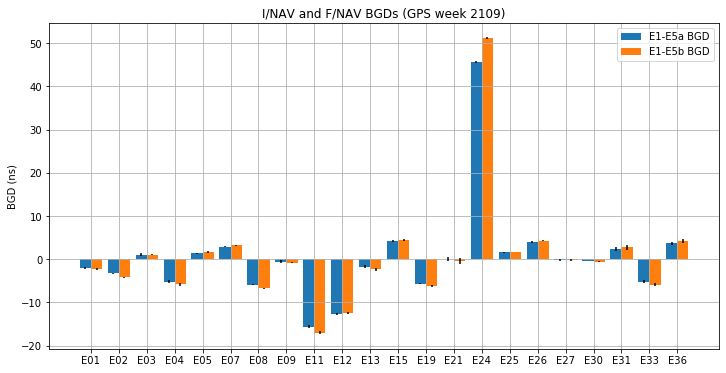

In [6]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.bar(np.arange(len(means_e5a))-0.2, means_e5a, yerr = stds_e5a, width = 0.4)
plt.bar(np.arange(len(means_e5b))+0.2, means_e5b, yerr = stds_e5b, width = 0.4)
plt.xticks(np.arange(len(means_e5a)), gal_sv)
plt.grid()
plt.legend(['E1-E5a BGD', 'E1-E5b BGD'])
plt.title(f'I/NAV and F/NAV BGDs (GPS week {week})')
plt.ylabel('BGD (ns)');

In [7]:
def af0_difference(svn):
    datasrc = rnx['DataSrc'].sel(sv = aliases(svn))
    datasrc = np.int32(datasrc.where(~np.isnan(datasrc), 0).values)
    src_e5a = datasrc & 0x100
    src_e5b = datasrc & 0x200
    af0_e5a = rnx['SVclockBias'].sel(sv = aliases(svn)).where(src_e5a).mean('sv')
    af0_e5b = rnx['SVclockBias'].sel(sv = aliases(svn)).where(src_e5b).mean('sv')
    return af0_e5a - af0_e5b

def af0(svn, band):
    datasrc = rnx['DataSrc'].sel(sv = aliases(svn))
    datasrc = np.int32(datasrc.where(~np.isnan(datasrc), 0).values)
    if band == 'E5a':
        sel = 0x100
    elif band == 'E5b':
        sel = 0x200
    else:
        raise ValueError('Invalid band')
    src = datasrc & sel
    return rnx['SVclockBias'].sel(sv = aliases(svn)).where(src).mean('sv')

In [8]:
af0_diffs = [af0_difference(svn) for svn in gal_sv]
af0_diff_means = [1e9*a.mean() for a in af0_diffs]
af0_diff_stds = [1e9*a.std() for a in af0_diffs]

/home/daniel/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


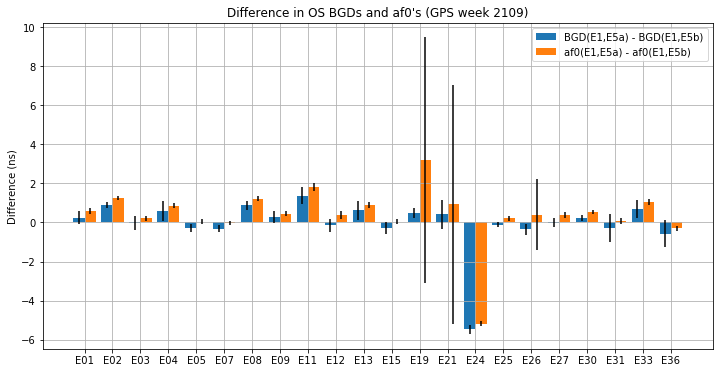

In [9]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.bar(np.arange(len(means_e5a))-0.2, np.array(means_e5a) - np.array(means_e5b),
        yerr = np.sqrt(np.array(stds_e5a)**2 + np.array(stds_e5b)**2), width = 0.4)
plt.bar(np.arange(len(means_e5b))+0.2, np.array(af0_diff_means), yerr = af0_diff_stds, width = 0.4)
plt.xticks(np.arange(len(means_e5a)), gal_sv)
plt.grid()
plt.legend(['BGD(E1,E5a) - BGD(E1,E5b)', 'af0(E1,E5a) - af0(E1,E5b)'])
plt.title(f'Difference in OS BGDs and af0\'s (GPS week {week})')
plt.ylabel('Difference (ns)');

In [10]:
def is_gal(x):
    return len(x) == 3 and x[0] == 'E'

dsb = list()
for p in data.glob('*.BSX'):
    with open(p) as f:
        dsb.extend([l for l in f if l.startswith(' DSB') and is_gal(l.split()[2])])

In [11]:
gal_sv_all = sorted({s.split()[2] for s in dsb})
sigs = ['C5Q', 'C6C', 'C7Q', 'C8Q']

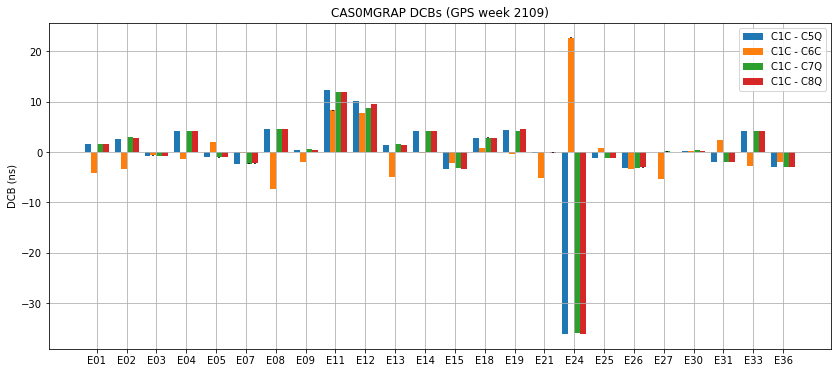

In [12]:
plt.figure(figsize = (14,6), facecolor = 'w')
for j,sig in enumerate(sigs):
    dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == svn and s.split()[4] == sig] for svn in gal_sv_all])
    means = np.average(dat[...,0], axis = -1)
    stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
    plt.bar(np.arange(len(means))-0.2*1.5+j*0.2, means, yerr = stds, width = 0.2)
plt.xticks(np.arange(len(means)), gal_sv_all)
plt.grid()
plt.legend([f'C1C - {sig}' for sig in sigs])
plt.title(f'CAS0MGRAP DCBs (GPS week {week})')
plt.ylabel('DCB (ns)');

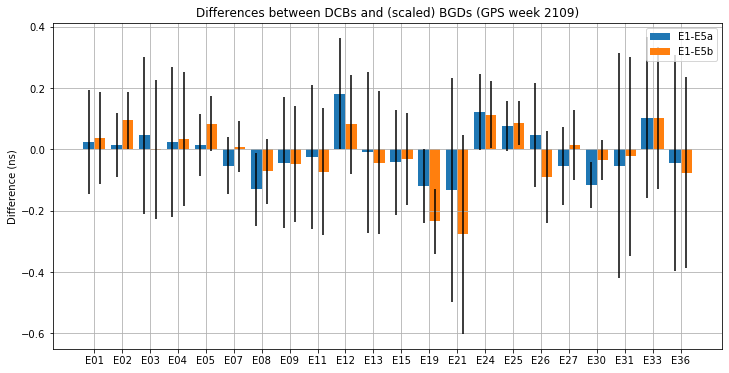

In [13]:
f1 = 1575.42
f2 = 1176.450
f3 = 1207.140

plt.figure(figsize = (12,6), facecolor = 'w')
dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == svn and s.split()[4] == 'C5Q'] for svn in gal_sv])
means = np.average(dat[...,0], axis = -1)
stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
plt.bar(np.arange(len(means))-0.2, means - np.array(means_e5a)*(1-(f1/f2)**2),
        yerr = np.sqrt(stds**2 + np.array(stds_e5a)**2*(1-(f1/f2)**2)**2), width = 0.4)
dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == svn and s.split()[4] == 'C7Q'] for svn in gal_sv])
means = np.average(dat[...,0], axis = -1)
stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
plt.bar(np.arange(len(means))+0.2, means - np.array(means_e5b)*(1-(f1/f3)**2),
        yerr = np.sqrt(stds**2 + np.array(stds_e5a)**2*(1-(f1/f3)**2)**2), width = 0.4)
plt.xticks(np.arange(len(means)), gal_sv)
plt.grid()
plt.legend(['E1-E5a', 'E1-E5b'])
plt.title(f'Differences between DCBs and (scaled) BGDs (GPS week {week})')
plt.ylabel('Difference (ns)');

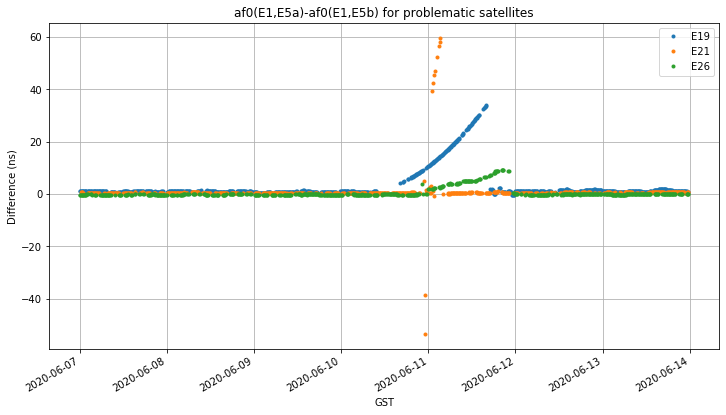

In [14]:
plt.figure(figsize = (12,6), facecolor = 'w')
for sv, ad in zip(gal_sv, af0_diffs):
    if np.std(1e9*ad) > 1:
        (1e9*ad).plot(marker = '.', linestyle = '', label = sv)
plt.legend()
plt.xlabel('GST')
plt.ylabel('Difference (ns)')
plt.title('af0(E1,E5a)-af0(E1,E5b) for problematic satellites')
plt.grid();

/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


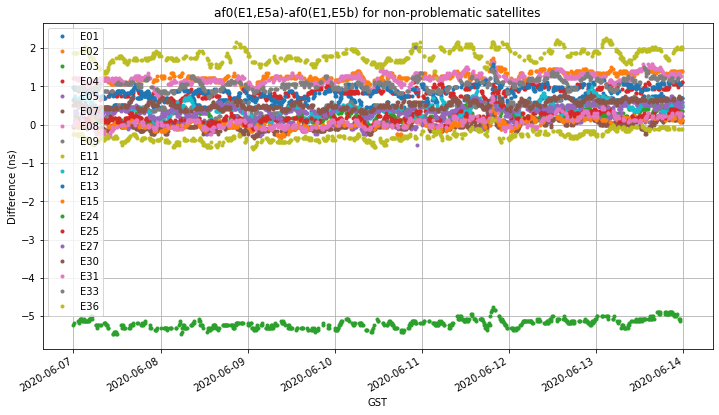

In [15]:
plt.figure(figsize = (12,6), facecolor = 'w')
for sv, ad in zip(gal_sv, af0_diffs):
    if np.std(1e9*ad) < 1:
        (1e9*ad).plot(marker = '.', linestyle = '', label = sv)
plt.legend()
plt.xlabel('GST')
plt.ylabel('Difference (ns)')
plt.title('af0(E1,E5a)-af0(E1,E5b) for non-problematic satellites')
plt.grid();

In [16]:
def load_clk(path, svn):
    times = list()
    clks = list()
    with open(path) as f:
        for line in f:
            if not line.startswith(f'AS {svn}'):
                continue
            clks.append(float(line.split()[9]))
            y, m, d, h, mm, s = line.split()[2:8]
            s = f'{int(float(s)):02d}'
            times.append(np.datetime64(f'{y}-{m}-{d}T{h}:{mm}:{s}'))
    return np.array(times), np.array(clks)

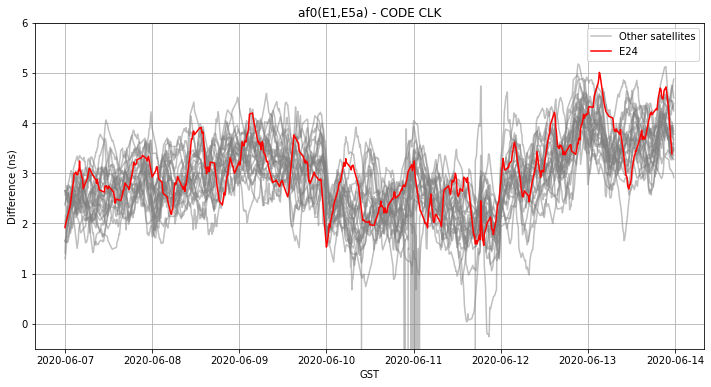

In [17]:
plt.figure(figsize = (12,6), facecolor = 'w')

for svn in sorted(set(gal_sv_all) - {'E24'}) + ['E24']:
    precise = [load_clk(f, svn) for f in data.glob('*.CLK')]
    precise_times = np.concatenate([r[0] for r in precise])
    precise_clks = np.concatenate([r[1] for r in precise])

    af0_e5a = af0(svn, 'E5a')
    af0_e5a = af0_e5a[~np.isnan(af0_e5a)]
    ts = (af0_e5a.time - af0_e5a.time[0]).values/np.timedelta64(1, 's')
    precise_clks_interp = np.interp(ts, (precise_times - af0_e5a.time[0].values)/np.timedelta64(1,'s'), precise_clks)

    label = {'label' : svn} if svn == 'E24' else {'label' : 'Other satellites'} if svn == 'E01' else {}
    plt.plot(af0_e5a.time, 1e9*(af0_e5a - precise_clks_interp),
            color = 'red' if svn == 'E24' else 'gray',
            alpha = 1 if svn == 'E24' else 0.5, **label)

plt.title('af0(E1,E5a) - CODE CLK')
plt.legend()
plt.xlabel('GST')
plt.ylabel('Difference (ns)')
plt.ylim((-0.5, 6))
plt.grid();

In [18]:
def parse_navdump(s):
    s = str(s, encoding = 'ascii')
    tows = list()
    clks = list()
    for line in s.split('\n'):
        if 'imptow' in line:
            tow = int(line.split()[-1])
        elif line.startswith('E24:  dclock0'):
            clk = float(line.split()[2])
            tows.append(tow)
            clks.append(clk)
    return tows, clks

def run_navdump(path):
    try:
        with open(path) as f:
            return parse_navdump(subprocess.run('/home/daniel/galmon/navdump', stdin = f, capture_output = True).stdout)
    except FileNotFoundError:
        return [[], []]

#load = False
load = True
if load:
    rtcm_data = np.load('rtcm_data.npz')
    rtcm_tows = rtcm_data['rtcm_tows']
    rtcm_clks = rtcm_data['rtcm_clks']
else:
    galmon_data = pathlib.Path('/home/daniel/galmon-data/2020/6')
    all_files = [galmon_data / str(day) / f'{hour}.pb.gnss' for day in range(7,14) for hour in range(24)]
    all_data = [run_navdump(f) for f in all_files]

    rtcm_tows = np.array([np.datetime64('2020-06-07') + np.timedelta64(1, 's')*x for a in all_data for x in a[0]])
    rtcm_clks = np.array([x for a in all_data for x in a[1]])
    np.savez('rtcm_data.npz', rtcm_tows = rtcm_tows, rtcm_clks = rtcm_clks)

/home/daniel/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/daniel/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


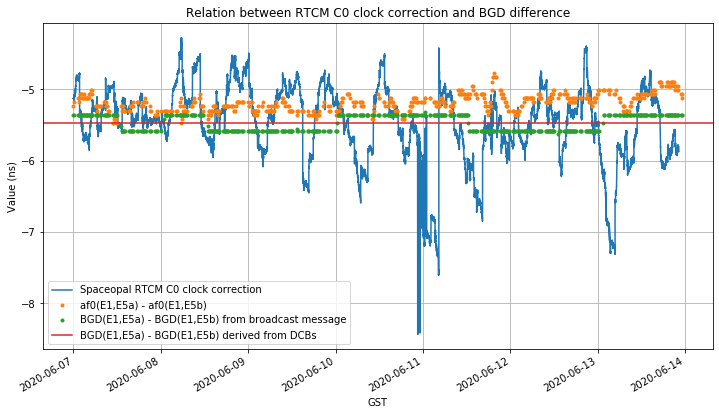

In [19]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(rtcm_tows, rtcm_clks/c*1e9, label = 'Spaceopal RTCM C0 clock correction')
(1e9*af0_diffs[gal_sv.index('E24')]).plot(marker = '.', linestyle = '', label = 'af0(E1,E5a) - af0(E1,E5b)')
(1e9*(mask_zeros(rnx['BGDe5a'].sel(sv = aliases('E24'))).mean('sv') 
     - mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn))).mean('sv'))).plot(marker = '.', linestyle = '',
                                                                         label = 'BGD(E1,E5a) - BGD(E1,E5b) from broadcast message')
dat = np.array([[float(s.split()[-2]) for s in dsb if s.split()[2] == 'E24' and s.split()[4] == sig]
                for sig in ['C5Q', 'C7Q']])
means = np.average(dat, axis = -1)
bgds_from_dcbs = means[0]/(1-(f1/f2)**2) - means[1]/(1-(f1/f3)**2)
plt.axhline(y = bgds_from_dcbs, color = 'C3',
            label = 'BGD(E1,E5a) - BGD(E1,E5b) derived from DCBs')
plt.legend()
plt.title('Relation between RTCM C0 clock correction and BGD difference')
plt.xlabel('GST')
plt.ylabel('Value (ns)')
plt.grid();

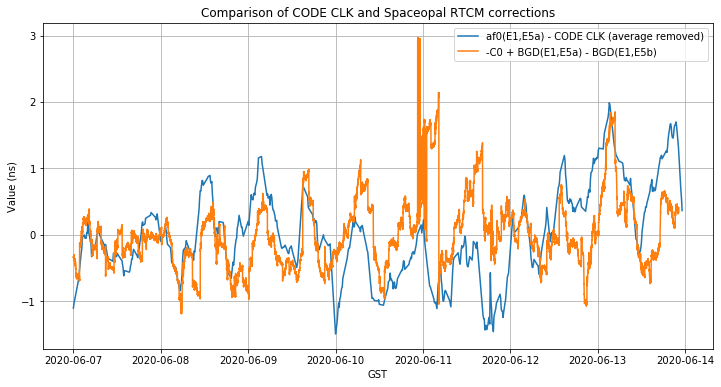

In [20]:
plt.figure(figsize = (12,6), facecolor = 'w')
precise = [load_clk(f, svn) for f in data.glob('*.CLK')]
precise_times = np.concatenate([r[0] for r in precise])
precise_clks = np.concatenate([r[1] for r in precise])

af0_e5a = af0(svn, 'E5a')
af0_e5a = af0_e5a[~np.isnan(af0_e5a)]
ts = (af0_e5a.time - af0_e5a.time[0]).values/np.timedelta64(1, 's')
precise_clks_interp = np.interp(ts, (precise_times - af0_e5a.time[0].values)/np.timedelta64(1,'s'), precise_clks)
af0_e5a_error = 1e9*(af0_e5a - precise_clks_interp)
af0_e5a_error -= np.average(af0_e5a_error)
plt.plot(af0_e5a.time, af0_e5a_error, label = 'af0(E1,E5a) - CODE CLK (average removed)')
plt.plot(rtcm_tows, -(rtcm_clks/c*1e9 - bgds_from_dcbs), label = '-C0 + BGD(E1,E5a) - BGD(E1,E5b)')
plt.title('Comparison of CODE CLK and Spaceopal RTCM corrections')
plt.xlabel('GST')
plt.ylabel('Value (ns)')
plt.legend()
plt.grid();

In [21]:
means

array([-36.084     , -35.83185714])

In [22]:
means[0] - means[1]

-0.2521428571428572

In [23]:
1/(1-(f1/f2)**2) - 1/(1-(f1/f3)**2)

0.16137279666418203

In [24]:
(1/(1-(f1/f2)**2) - 1/(1-(f1/f3)**2)) * (1-(f1/f2)**2)

-0.12801225026872848